# Tag Classificaiton using TFBert Model

In [4]:
import pandas as pd

In [5]:
data = pd.read_csv("MediumDataAfterEDA.csv")
data.head(2)

,title,Author,Upvote,CommentCount,Publish Date,Read Time,Paragraph,Links,Tag,Weekday,Month,Year,BlogLength,Consolidated Tag
0,DrivenData Interview,Will Koehrsen,544,2,14 Dec 2020,13,"In October 2020, I was interviewed by DrivenDa...",https://williamkoehrsen.medium.com/drivendata-...,Data Science,Monday,December,2020,15939,Data Science
1,A Data Science Conversation,Will Koehrsen,411,43,10 Mar 2020,3,Talking is a lot like writing in that it force...,https://williamkoehrsen.medium.com/a-data-scie...,Data Science,Tuesday,March,2020,1379,Data Science


In [6]:
df = data[["Paragraph","Tag"]].copy()
df.head(1)

,Paragraph,Tag
0,"In October 2020, I was interviewed by DrivenDa...",Data Science


### Chunking the large blogs into 80 words with 20 overlapping words, so to increase dataset just from 155 Blogs

In [7]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def create_overlapping_segments(text, chunk_size=100, overlap=20):
  """
    Function to create overlapping segments of text with specified chunk size and overlap.

    Parameters:
        text (str): The input text to be segmented.
        chunk_size (int): The desired chunk size in terms of number of words.
        overlap (int): The overlap between adjacent chunks in terms of number of words.

    Returns:
        List of overlapping segments.
  """
  tokens = word_tokenize(text)
  segments = []
  start = 0
  end = chunk_size
  while start < len(tokens):
    segment = tokens[start:end]
    segments.append(" ".join(segment))
    start += chunk_size - overlap
    end = start + chunk_size
  return segments

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
X = []
Y = []
for i in range(len(df["Paragraph"])):
  segment =  create_overlapping_segments(df["Paragraph"][i])
  for sentence in segment:
    X.append(sentence)
    Y.append(df["Tag"][i])

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Pre-processing steps :
- First removing punctuation and html tags if any. note that the html tas may be present ast the data must be scraped from net.

- Tokenize the reviews into tokens or words .

- Next remove the stop words and shorter words as they cause noise.

- Stem or lemmatize the words depending on what does better. Herer I have yse lemmatizer.

In [11]:
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
  sentence = text.lower()
  sentence = re.sub("[^a-z0-9]",' ',sentence)
  sentence = sentence.split()
  sentence = [lemmatizer.lemmatize(word) for word in sentence if word not in STOPWORDS]
  sentence = " ".join(sentence)
  return sentence

In [12]:
new_df = pd.DataFrame({"Blog": X, "Tag": Y})

### using Label Encoder to Encode Tags

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
new_df["Tag_Encoded"] = label_encoder.fit_transform(new_df["Tag"])
new_df["Tag_Encoded"].unique()

array([0, 3, 5, 2, 4, 1])

In [14]:
len(new_df)

5416

In [15]:
import tensorflow
from tensorflow.keras.utils import to_categorical

### Splitting The Dataset Before Training

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train_df,y_test_df = train_test_split(new_df.Blog, new_df.Tag_Encoded,test_size=0.1,random_state=42, stratify=new_df.Tag_Encoded)

In [17]:
x_train.shape

(4874,)

In [18]:
y_train = to_categorical(y_train_df)
y_test = to_categorical(y_test_df)

In [19]:
len(y_train[0])

6

In [20]:
y_test

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

### Installing Transformer

In [21]:
!pip install transformers
import transformers

### Using AutoTokenizer to Tokenize and importing pretrained bert model named "bert-base-cased"

In [22]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFBertModel.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Tokenizing the input which will be given to Model (takes some time)
### Here tokenizer using from bert-base-cased

In [23]:

x_train_tokenized = tokenizer(
    text=x_train.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_tokenized = tokenizer(
    text=x_test.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [24]:
len(x_train_tokenized[1])

70

### Extracting input_ids and attention_mask from tokenized data as this is required input during training Bert Mode

In [25]:
input_ids = x_train_tokenized['input_ids']
attention_mask = x_train_tokenized['attention_mask']

In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [27]:
max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(6,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 70)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 70, 76                                       

In [29]:
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
loss =CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy'),
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)

In [30]:
train_history = model.fit(
    x ={'input_ids':x_train_tokenized['input_ids'],'attention_mask':x_train_tokenized['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test_tokenized['input_ids'],'attention_mask':x_test_tokenized['attention_mask']}, y_test
    ),
  epochs=5,
    batch_size=36
)

Epoch 1/5


136/136 [==============================] - 3959s 29s/step - loss: 1.0510 - balanced_accuracy: 0.5927 - val_loss: 0.7623 - val_balanced_accuracy: 0.7177
Epoch 2/5
136/136 [==============================] - 3886s 29s/step - loss: 0.6479 - balanced_accuracy: 0.7526 - val_loss: 0.6429 - val_balanced_accuracy: 0.7565
Epoch 3/5
136/136 [==============================] - 3898s 29s/step - loss: 0.4507 - balanced_accuracy: 0.8389 - val_loss: 0.6620 - val_balanced_accuracy: 0.7675
Epoch 4/5
136/136 [==============================] - 3940s 29s/step - loss: 0.3320 - balanced_accuracy: 0.8867 - val_loss: 0.6027 - val_balanced_accuracy: 0.7860
Epoch 5/5
136/136 [==============================] - 3899s 29s/step - loss: 0.2398 - balanced_accuracy: 0.9237 - val_loss: 0.6998 - val_balanced_accuracy: 0.7638


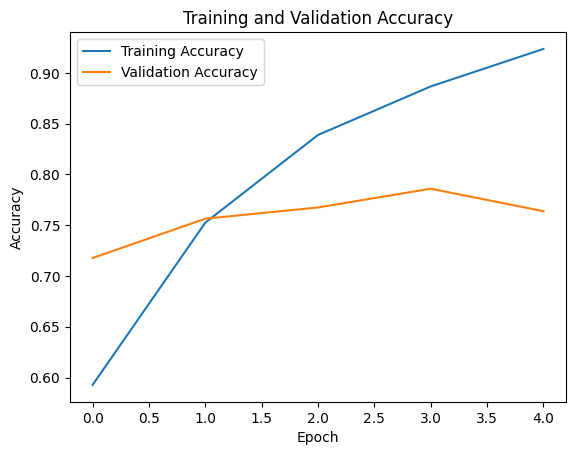

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_history.history['balanced_accuracy'], label='Training Accuracy')
plt.plot(train_history.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
evaluation = model.evaluate(
    x={'input_ids': x_test_tokenized['input_ids'], 'attention_mask': x_test_tokenized['attention_mask']},
    y=y_test
)

17/17 [==============================] - 148s 8s/step - loss: 0.6998 - balanced_accuracy: 0.7638


In [36]:
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Test Loss: 0.6998120546340942
Test Accuracy: 0.7638376355171204
